In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import pulp
import seaborn as sns



sns.set(style="whitegrid")

from IPython.core.display import HTML

from scipy.sparse import linalg as sparse_linalg, issparse
from scipy.spatial.distance import cdist, euclidean

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
from sklearn.utils import shuffle
from sklearn.utils.extmath import safe_sparse_dot

from tqdm import tqdm

from xrun.data.run_info import RunInfo
from xrun.data.loader import load_dataset

In [3]:
def compute_real_cost(data_points: np.ndarray, center_points: np.ndarray):
    D = pairwise_distances(data_points, center_points, metric="sqeuclidean")
    dist_closest_centers = np.min(D, axis=1)
    cost = np.sum(dist_closest_centers)
    return cost

def compute_coreset_costs(coreset_points: np.ndarray, coreset_weights: np.ndarray, center_points: np.ndarray):
    D = pairwise_distances(coreset_points, center_points, metric="sqeuclidean")
    dist_closest_centers = np.min(D, axis=1)
    weighted_cost = np.sum(coreset_weights * dist_closest_centers)
    return weighted_cost

def estimate_optimal_cost(data_matrix: np.ndarray, k: int, n_iter: int=10):
    km = KMeans(n_clusters=k, n_init=n_iter, max_iter=1)
    km.fit(data_matrix)
    return km.inertia_

In [4]:
# data_centers = np.random.randint(low=2, high=5)
true_centers = np.array([
    [ 0,  0],
    [-5, -5],
    [-5,  5],
    [ 5,  -6],
])
raw_data, labels = make_blobs(n_samples=200, centers=true_centers, random_state=42)

In [5]:
k = true_centers.shape[0]
n_points = raw_data.shape[0]

In [6]:
km = KMeans(n_clusters=k*2, n_init=10, max_iter=1)
km.fit(raw_data)
coreset_points = km.cluster_centers_

_, coreset_weights = np.unique(km.labels_, return_counts=True)

n_coreset_points = coreset_points.shape[0]

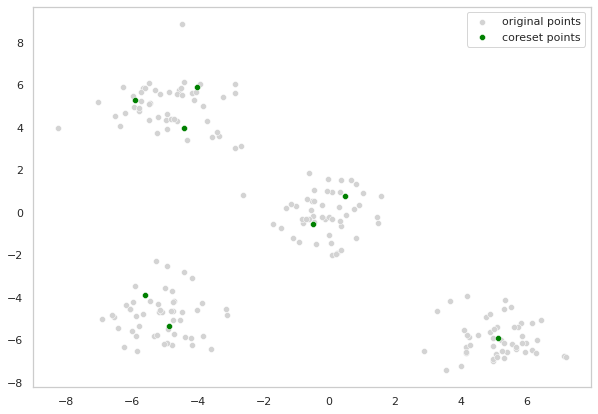

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", label="original points", ax=ax)
sns.scatterplot(x=coreset_points[:,0], y=coreset_points[:,1], color="green", label="coreset points", ax=ax)
ax.grid(False)

In [8]:
input_point_indices = np.arange(start=0, stop=n_points)
coreset_point_indices = np.arange(start=0, stop=n_coreset_points)
clustering_center_indices = np.arange(start=0, stop=k)

In [9]:
input_pairs = [(i, j) for i in input_point_indices for j in input_point_indices]
coreset_pairs = [(i, j) for i in coreset_point_indices for j in input_point_indices]

In [10]:
# X[i,j] \in [0,1] is a variable indicating whether point i is assigned to center j.
# X = np.zeros(shape=(n_points, k))
X = pulp.LpVariable.dicts(
    name="X",
    indices=input_pairs, 
    lowBound=0,
    upBound=1, 
)

In [11]:
# Y[i,j] \in [0,1] is a variable indicating whether coreset point i is assigned to center j.
# Y = np.zeros(shape=(n_coreset_points, k))
Y = pulp.LpVariable.dicts(
    name="Y",
    indices=coreset_pairs, 
    lowBound=0,
    upBound=1, 
)

In [12]:
#z[j] \in [0,1] is a variable indicating whether we have a center at point j.
# z = np.zeros(shape=(n_points, 1))
z = pulp.LpVariable.dicts(
    name="z",
    indices=[i for i in input_point_indices],
    lowBound=0,
    upBound=1, 
)

In [13]:
optimal_cost = estimate_optimal_cost(data_matrix=raw_data, k=k, n_iter=10)
optimal_cost

363.5232175864159

In [14]:
input_dist = pairwise_distances(X=raw_data, metric="sqeuclidean")
coreset_dist = pairwise_distances(X=coreset_points, Y=raw_data, metric="sqeuclidean")

In [15]:
lp_problem = pulp.LpProblem("max_distortion_problem", pulp.LpMaximize)

# Set the objective
x_vals = [ (X[(i, j)], input_dist[i,j]) for i, j in input_pairs if input_dist[i,j] > 0]
y_vals = [ (Y[(i, j)], -1 * coreset_dist[i,j] * coreset_weights[i]) for i, j in coreset_pairs if coreset_dist[i,j] * coreset_weights[i] > 0]
lp_problem += pulp.LpAffineExpression(x_vals + y_vals)

lp_problem += (pulp.lpSum([z[j] for j in range(n_points)]) == k, "constraint_exactly_k_centers")

lp_problem += ( pulp.LpAffineExpression(x_vals) <= 2*optimal_cost, "constraint_below_2OPT")

for i in range(n_points):
    lp_problem += (pulp.lpSum([X[i,j] for j in range(n_points)]) == 1, f"constraint_input_point_{i}_has_cluster")

for i in range(n_points):
    for j in range(n_points):
        lp_problem += (X[i,j] <= z[j],
            f"constraint_input_point_{i}_has_cluster{j}"
        )


for i in range(n_coreset_points):
    lp_problem += (pulp.lpSum([Y[i,j] for j in range(n_points)]) == 1, f"constraint_coreset_point_{i}_has_cluster")

for i in range(n_coreset_points):
    for j in range(n_points):
        lp_problem += (Y[i,j] <= z[j],
            f"constraint_coreset_point_{i}_has_cluster_{j}"
        )
        
lp_problem.writeLP("max_distortion_problem.lp")
        
lp_problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/omar/.cache/pypoetry/virtualenvs/xrun-eubxByDy-py3.8/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/6c4a63087ed143f2862bf8586ffe26b2-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/6c4a63087ed143f2862bf8586ffe26b2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 41815 COLUMNS
At line 248016 RHS
At line 289827 BOUNDS
At line 331628 ENDATA
Problem MODEL has 41810 rows, 41800 columns and 164800 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 41810 (0) rows, 41800 (0) columns and 164800 (0) elements
0  Obj -0 Primal inf 747.1561 (209) Dual inf 338996.22 (39800)
434  Obj 727.04644 Primal inf 522681.14 (2202)
868  Obj 727.04644 Primal inf 394989.39 (2569)
1302  Obj 727.04644 Primal inf 2344376.4 (5573)
1736  Obj 727.03754 Primal inf 1033548.8 (14051)
2170  Obj 727

1

In [16]:
print("Status:", pulp.LpStatus[lp_problem.status])

Status: Optimal


In [17]:
y_cluster_indices = set()
for i,j in Y:
    if Y[(i,j)].value():
        y_cluster_indices.add(j)
y_cluster_indices

{1, 17, 83, 165}

In [18]:
x_cluster_indices = set()
for i,j in X:
    if X[(i,j)].value():
        x_cluster_indices.add(j)
x_cluster_indices

{1, 17, 83, 165}

In [19]:
clustering_solution_indices = [i for i in range(n_points) if z[i].value()]
clustering_solution_indices

[1, 17, 83, 165]

In [20]:
clustering_solution_centers = raw_data[clustering_solution_indices]

In [21]:
real_cost = compute_real_cost(
    data_points=raw_data,
    center_points=clustering_solution_centers,
)
coreset_cost = compute_coreset_costs(
    coreset_points=coreset_points,
    coreset_weights=coreset_weights,
    center_points=clustering_solution_centers,
)
distortion = max(float(real_cost/coreset_cost), float(coreset_cost/real_cost))

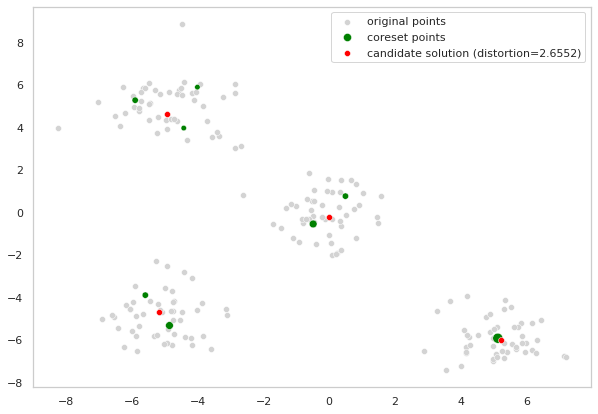

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", label="original points", ax=ax)
sns.scatterplot(x=coreset_points[:,0], y=coreset_points[:,1], s=coreset_weights*2, color="green", label="coreset points", ax=ax)
sns.scatterplot(x=clustering_solution_centers[:,0], y=clustering_solution_centers[:,1], color="red", label=f"candidate solution (distortion={distortion:0.4f})", ax=ax)
ax.grid(False)

## Finding worst distortion

In [23]:
n_iterations = 1000
worst_distortion = 0
worst_solution = None

with tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):

        km = KMeans(n_clusters=k, n_init=1, max_iter=1)
        km.fit(raw_data)
        candidate_sol = km.cluster_centers_

        real_cost = compute_real_cost(
            data_points=raw_data,
            center_points=candidate_sol,
        )
        coreset_cost = compute_coreset_costs(
            coreset_points=coreset_points,
            coreset_weights=coreset_weights,
            center_points=candidate_sol,
        )
        distortion = max(float(real_cost/coreset_cost), float(coreset_cost/real_cost))
        
        if distortion > worst_distortion:
            worst_distortion = distortion
            worst_solution = candidate_sol.copy()
        pbar.update()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 609.25it/s]


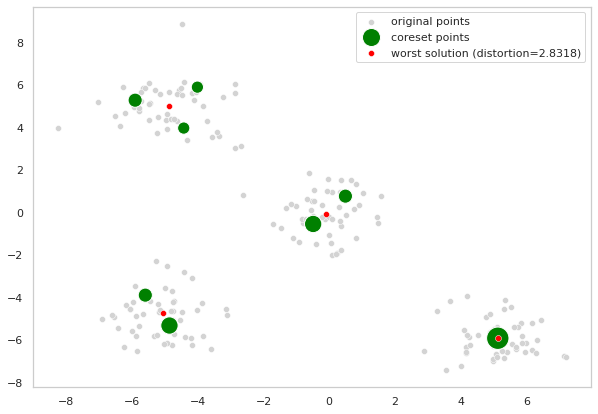

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", label="original points", ax=ax)
sns.scatterplot(x=coreset_points[:,0], y=coreset_points[:,1], s=coreset_weights*10, color="green", label="coreset points", ax=ax)
sns.scatterplot(x=worst_solution[:,0], y=worst_solution[:,1], color="red", label=f"worst solution (distortion={worst_distortion:0.4f})", ax=ax)
ax.grid(False)

## Find low cost solution

In [25]:
n_iterations = 1000
lowest_cost = None
lowest_cost_solution = None

with tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        

        km = KMeans(n_clusters=k, n_init=1, max_iter=1)
        km.fit(raw_data)
        candidate_sol = km.cluster_centers_

        real_cost = compute_real_cost(
            data_points=raw_data,
            center_points=candidate_sol,
        )
        if i == 0:
            lowest_cost = real_cost
        
        if real_cost <= lowest_cost:
            lowest_cost = real_cost
            lowest_cost_solution = candidate_sol.copy()
        pbar.update()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 660.39it/s]


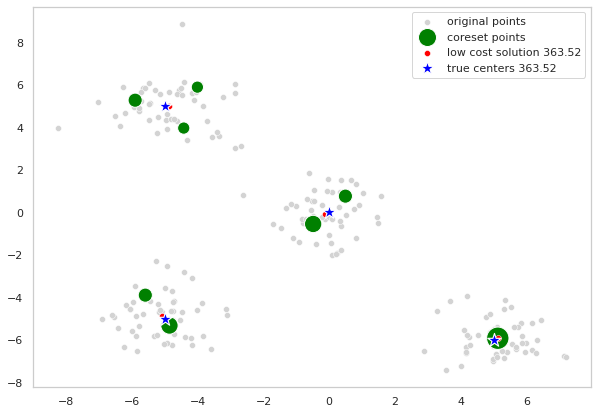

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", label="original points", ax=ax)
sns.scatterplot(x=coreset_points[:,0], y=coreset_points[:,1], s=coreset_weights*10, color="green", label="coreset points", ax=ax)
sns.scatterplot(x=lowest_cost_solution[:,0], y=lowest_cost_solution[:,1], color="red", label=f"low cost solution {lowest_cost:0.2f}", ax=ax)
sns.scatterplot(x=true_centers[:,0], y=true_centers[:,1], color="blue", marker="*", s=200, label=f"true centers {optimal_cost:0.2f} ", ax=ax)
ax.grid(False)